# Notebook created 10/04/2025
# How to compute HLD 10th percentile and impact on SHX events

In [92]:
import xarray as xr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs


# 0 - Definition Functions

In [93]:
# Function to group events when they are less than 3 days apart
def fun(data):
    return np.split(data, np.where(np.diff(data) >= 3)[0]+1)

# 1- Read HLD file

In [94]:
dirdata='/data/ghervieux/GLORYS_BGC'
ds=xr.open_dataset(f'{dirdata}/DSrhypoxicboundary.nc')
hld=ds['hypoxicboundary']

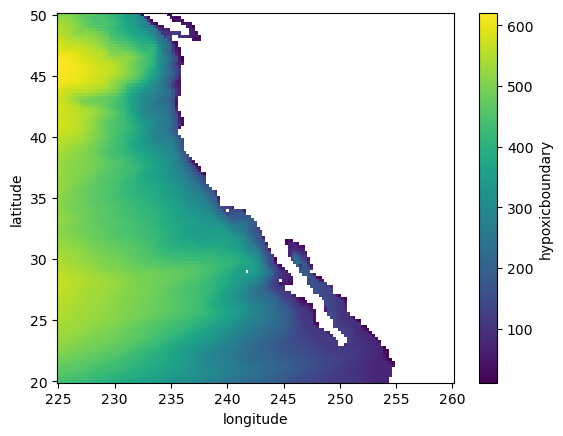

In [95]:
hld.mean('time').plot()


# Read mask zone 4

In [96]:
DSmask=xr.open_dataset(f'{dirdata}/mask_GLORYSBGC_Newzones.nc')
maskD=DSmask['mask_zoneD']

# Read Bottom Depth for GLORYS-BGC

In [97]:
filedepth='/Projects/Air_Sea/jscott/FREEGLORYS2V4/Statics/GLOBAL_REANALYSIS_BIO_001_029_mask.wc.nc'
DSdepth=xr.open_dataset(filedepth)
deptho=DSdepth['deptho']

# Choose of Lon/Lat 

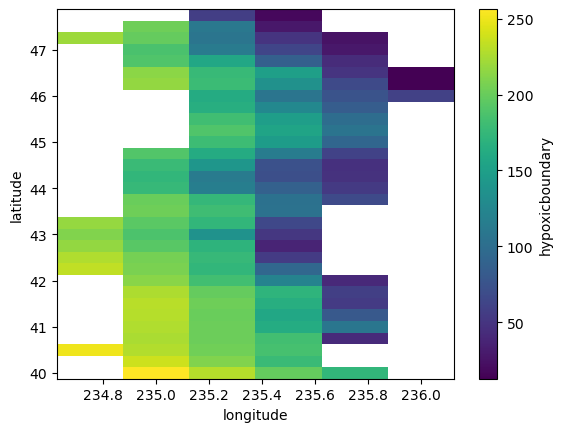

In [98]:
hld=hld.where(maskD==1,drop=True)
hld.mean('time').plot()

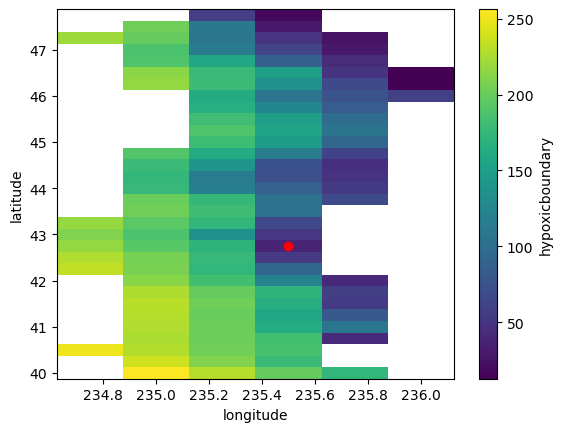

In [99]:
lon=235.5;lat=42.75
hldij=hld.sel(longitude=lon,latitude=lat)
hld.mean('time').plot()
plt.scatter(lon,lat,marker='o',color='red')

# Extract Bottom depth for that specific point

In [100]:

depthij=deptho.sel(longitude=lon,latitude=lat)
print(depthij.values)

38.3871


2 - PLOT hld timeseries


Text(0.5, 1.0, 'HLD with undefined depth :hld_n')

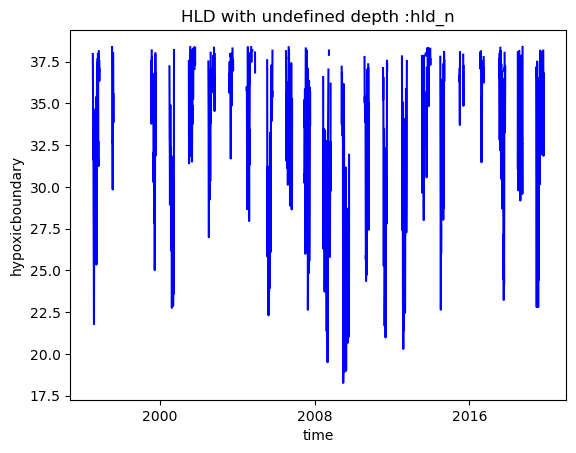

In [101]:
# Define HLD with undefined depth at point lon/lat: hld_n
hld_n=hldij.where(hldij<depthij)
hld_n.plot(c='blue')
plt.title('HLD with undefined depth :hld_n')

Text(0.5, 1.0, 'HLD with undefined depth set to 38: hld_d')

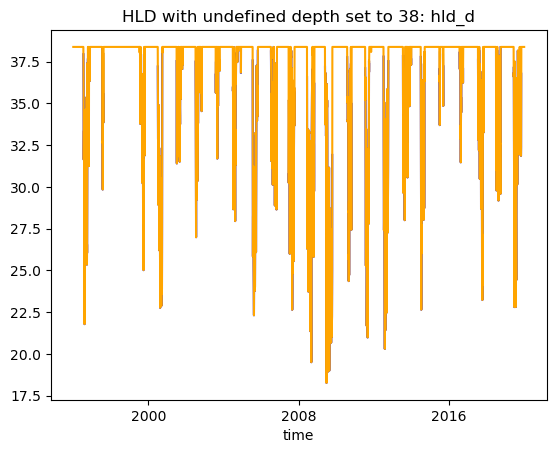

In [102]:
# Define HLD with undefined depth set to the bottom at point lon/lat: hld_d
hld_d=xr.where(hldij>=depthij,depthij,hldij)
hld_n.plot(c='blue')
hld_d.plot(c='orange',ls='-')

plt.title('HLD with undefined depth set to %d: hld_d' % depthij.data)

# 3 - Define 10th percentile
Hobday et al., 2016 method with an 11-day window size centered on the day of the year.

In [ ]:
# 
doy=ds.time.dt.dayofyear
th10_n=xr.zeros_like(hld_n.groupby('time.dayofyear').mean('time'))
th10_d=xr.zeros_like(hld_d.groupby('time.dayofyear').mean('time'))

for iday in range(1,366):
  # compute percentile for hld_n
  th10_n[iday-1]=hld_n.rolling(time=11, center=True).construct(time='timeroll').sel(time=(doy ==iday )).quantile(0.10,skipna=True,dim=('time','timeroll'))
  # compute percentile for hld_d
  th10_d[iday-1]=hld_d.rolling(time=11, center=True).construct(time='timeroll').sel(time=(doy ==iday )).quantile(0.10,skipna=True,dim=('time','timeroll'))

# Plot percentile

Text(0.5, 1.0, 'HLD 10th percentile')

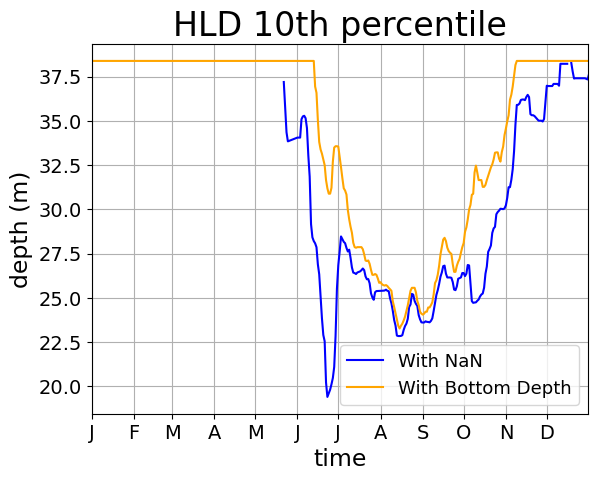

In [104]:
day2month=[0,31,59,90,120,151,181,212,243,273,304,334]
Nmonth=['J','F','M','A','M','J','J','A','S','O','N','D']
#
th10_n.plot(color='blue',label='With NaN')
th10_d.plot(color='orange',label='With Bottom Depth')
plt.legend(loc='lower right',fontsize=13)
plt.grid()
plt.xlim(0,364)
plt.yticks(fontsize=14)
plt.xticks(day2month[:],labels=Nmonth,fontsize=14)
plt.xlabel('time',fontsize=17)
plt.ylabel('depth (m)',fontsize=17)
plt.title('HLD 10th percentile',fontsize=24)


# 4 - Define SHX Events

a - HLD With Undefined Depth

In [105]:
# Extent 10th percentile to 24*365 array
th10_nE=th10_n.sel(dayofyear=ds.time.dt.dayofyear)
# Define when HLD < HLD_10thpercentile
Tper_n=xr.where((hld_n<th10_nE),1,0)
# Define Events
yyy_n=np.where(Tper_n==1)[0]
# Group Events when less (or equal) than 3 days apart
zzz_n=fun(yyy_n)
# Delete Events < 5 days
zzz_n=[ x for x in zzz_n if not (len(x)<5)]
# Define Events time series
Events_n=xr.zeros_like(hld_n)
for i in range(0,len(zzz_n)):
  Events_n[zzz_n[i]]=1.
#


b - HLD With Undefined Depth set to Bottom Depth

In [106]:
# Extent 10th percentile to 24*365 array
th10_dE=th10_d.sel(dayofyear=ds.time.dt.dayofyear)
# Define when HLD < HLD_10thpercentile
Tper_d=xr.where((hld_d<th10_dE),1,np.nan)
# Define Events
yyy_d=np.where(Tper_d==1)[0]
# Group Events when less (or equal) than 3 days apart
zzz_d=fun(yyy_d)
# Delete Events < 5 days
zzz_d=[ x for x in zzz_d if not (len(x)<5)]
# Define Events time series
Events_d=xr.zeros_like(hld_d)
for i in range(0,len(zzz_d)):
  Events_d[zzz_d[i]]=1.

# 5- PLOTS Events

In [ ]:
year=ds.indexes['time'].to_datetimeindex()

#

fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,6),num=2,clear=True)
fig.subplots_adjust(hspace=.05,wspace=.2,top=0.8)
axs[0].plot(year,hld_n,color='blue',linewidth=1.,label='with NAN')
axs[0].plot(year,th10_nE, color='blue',linestyle='dashed',linewidth=.5,label='10th percentile')
axs[0].fill_between(year,hld_n,th10_nE,np.where(Tper_n==1,True,False),color='green', alpha=0.5)
axs[0].grid()
axs[0].set_ylabel(r'm',fontsize=16)
axs[0].set_xlim(year[0],year[-1])
axs[0].set_xticklabels([])
axs[0].set_ylim(axs[0].get_ylim()[0],axs[0].get_ylim()[1])
axs[0].set_yticklabels([round(ix) for ix in axs[0].get_yticks()],fontsize=16)
f1=axs[0].fill_between(year,axs[0].get_ylim()[0],axs[0].get_ylim()[1],\
            np.where(Events_n==1,True,False), color='green', alpha=0.5,edgecolor=None,label='SHX')
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left',ncol=2,
        bbox_to_anchor=(0.1,0.93), prop={'size': 14})
axs[1].plot(year,hld_d,color='orange',linewidth=1.,label='with Bottom Depth')
axs[1].plot(year,th10_dE, color='orange',linestyle='dashed',linewidth=.5,label='10th percentile')
axs[1].fill_between(year,hld_d,th10_dE,np.where(Tper_d==1,True,False),color='red', alpha=0.5)
axs[1].grid()
axs[1].set_ylabel(r'm',fontsize=16)
axs[1].set_xlim(year[0],year[-1])
axs[1].set_ylim(axs[1].get_ylim()[0],axs[1].get_ylim()[1])
axs[1].set_yticklabels([round(ix) for ix in axs[1].get_yticks()],fontsize=16)
axs[1].set_xticklabels(axs[1].get_xticklabels(),fontsize=16)
f1=axs[1].fill_between(year,axs[1].get_ylim()[0],axs[1].get_ylim()[1],\
            np.where(Events_d==1,True,False), color='red', alpha=0.5,edgecolor=None,label='SHX')
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left',ncol=2,
        bbox_to_anchor=(0.5,.93), prop={'size': 14})
plt.xlabel('')


# 6 - Caracteristics 

In [108]:
# With NaN
#Effective percentage of SHX
per_n=Events_n.sum()/len(ds.time)*100.
print(f'Effective percentage of SHX with NaN={np.round(per_n.data,2)}')
# With Bottom Deptj
#Effective percentage of SHX
per_d=Events_d.sum()/len(ds.time)*100.
print(f'Effective percentage of SHX with bottom depth={np.round(per_d.data,2)}')

Effective percentage of SHX with NaN=1.44
Effective percentage of SHX with bottom depth=3.84


# 7 - Example for quantile understanding over 11*24 points

In [109]:
test[:]=np.random.rand(264)
test=xr.DataArray(test,dims='time')
print(test)

test2=test.copy()
test2[-56::]=np.NaN
test3=test2.where(np.isnan(test2)==False,drop=True)

# compute percentile for test
th10_t=test.quantile(0.10,skipna=True)
# compute percentile for test2
th10_t2=test2.quantile(0.10,skipna=True)
# compute percentile for test3
th10_t3=test3.quantile(0.10,skipna=True)

<xarray.DataArray (time: 264)>
array([0.13013868, 0.58707253, 0.02622031, 0.9239999 , 0.92591963,
       0.28281441, 0.24721602, 0.98016741, 0.52590086, 0.12929143,
       0.37488174, 0.93541694, 0.93149038, 0.06295856, 0.19853871,
       0.20137469, 0.05704051, 0.33965993, 0.48972798, 0.5053184 ,
       0.27859199, 0.44379793, 0.69658585, 0.71269826, 0.35113833,
       0.99954307, 0.42510763, 0.71159182, 0.61745575, 0.60387187,
       0.64915371, 0.68392517, 0.27812213, 0.94426761, 0.80907578,
       0.99163365, 0.85497843, 0.00375173, 0.59556685, 0.79378524,
       0.15488442, 0.51861894, 0.43108444, 0.61315651, 0.78245097,
       0.00651218, 0.8458482 , 0.09478694, 0.77846674, 0.72910115,
       0.4821713 , 0.0187111 , 0.28799267, 0.93128859, 0.56676275,
       0.3962083 , 0.21205591, 0.3471841 , 0.95372199, 0.39063168,
       0.05736372, 0.77750582, 0.74424561, 0.51447156, 0.33939021,
       0.71734569, 0.89233633, 0.28940135, 0.59793227, 0.34575007,
       0.58620226, 0.89643371, 

In [110]:
print(th10_t.data)
print(th10_t2.data)
print(th10_t3.data)

0.09580043566728005
0.1238454301852152
0.1238454301852152


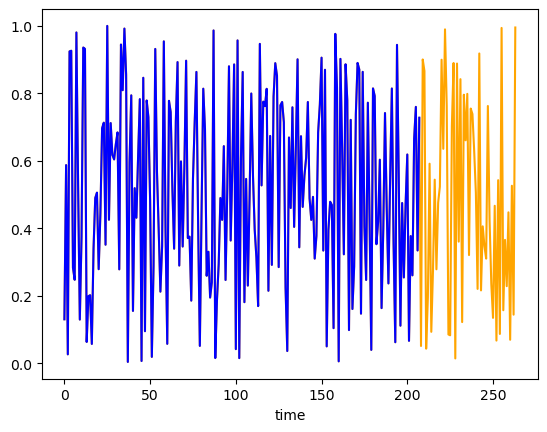

In [111]:
test.plot(c='orange')
test2.plot(c='blue')

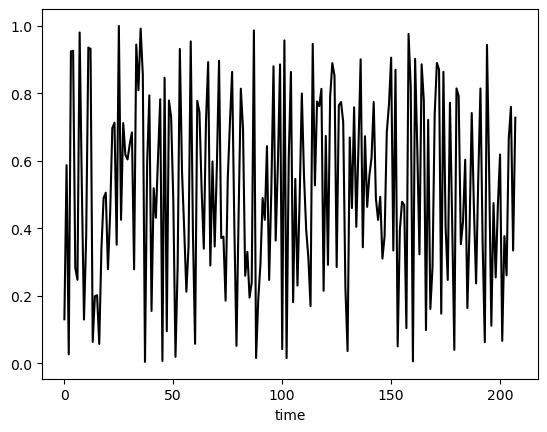

In [112]:
test3.plot(c='black') 